In [1]:
import torch.nn as nn
from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as dset
from IPython.display import display, clear_output
from torch.autograd import Variable
import time
import pdb

In [2]:
def ETA(ep, epoch, i, bs, dt, total_bs):
    sec_left = (dt * (total_bs - i)) + dt * (epoch - ep) * (total_bs)
    #print(dt)
    #print(sec_left)
    #print(np.floor(sec_left / 3600), np.floor((sec_left%3600)/60),
    #              np.floor((sec_left%3600)%60))
    eta = "ETA: %d hours  %d min  %d sec" % (np.floor(sec_left / 3600),
                                            np.floor((sec_left%3600)/60),
                                            np.floor((sec_left%3600)%60))
    return eta

#---------------------------------------------------------------------
def status(batch_size, ep, epoch, i, loss, data_loader, eta):
    # status
    clear_output(wait=True)
    print(str(ep) + '/' + str(epoch), '\n',
          'batch: ' + str(i+1) + '/' + str(len(data_loader)) + 
             ' [' + '='*int((i+1)/(len(data_loader)/20)) +
              '>' + ' '*(20 - int((i+1)/(len(data_loader)/20))) +
              ']', '\n',
          'Loss: %.4g '% (loss), '\n',
          eta)
#-------------------------------------------------------------------
def showAllImages(x,y,z):
    x = x[1,0:3,:,:].detach()
    y = y[1,0:3,:,:].detach()
    z = z[1,0:3,:,:].detach()
    
    x = x.cpu()
    y = y.cpu()
    z = z.cpu()
    
    plt.figure(figsize=(12,8))
    plt.subplot(131)
    plt.imshow(np.transpose(x, (1,2,0)))
    plt.subplot(132)
    plt.imshow(np.transpose(y, (1,2,0)))
    plt.subplot(133)
    plt.imshow(np.transpose(z, (1,2,0)))
    plt.show()

#-------------------------------------------------------------------
def conv4rnn(dimIn, dimOut):
    #print(dimIn,dimOut)
    model = nn.Sequential(
        nn.Conv2d(dimIn, dimOut, kernel_size=3, stride=1,
                  padding=1),
        nn.BatchNorm2d(dimOut)
    )
    return model

In [12]:
class convRNNcell(nn.Module):
    def __init__(self, inSize, inDim, hidSize):
        super().__init__()
        self.inSize = inSize
        self.hidSize = hidSize
        self.height, self.width = inDim
        
        self.conv = conv4rnn(self.inSize + self.hidSize,
                             2 * self.hidSize)
        
    def forward(self, xt, state):
        ht_1 = state
        
        concat = torch.cat([xt, ht_1], dim=1)
        
        conconv = self.conv(concat)
        ccx, cch = torch.split(conconv, self.hidSize, dim=1)
        
        ht = torch.tanh(ccx + cch)
        
        return ht
    
    def init_hidden(self, batchSize):
        state = (Variable(torch.zeros(batchSize, self.hidSize,
                                     self.height, self.width)))
        return state
    
#---------------------------------------------------------------------
class convRNN(nn.Module):
    def __init__(self, inSize, inDim, hidSize, layers, seqLen):
        super().__init__()
        self.inSize = inSize
        self.hidSize = hidSize
        self.height, self.width = inDim
        self.inDim = inDim
        self.layers = layers
        self.seqLen = seqLen
        
        cells= []
        for i in range(0, self.layers):
            dim = self.inDim if i == 0 else self.hidSize

            cells.append(convRNNcell(inSize=self.inSize,
                                     inDim=self.inDim,
                                     hidSize=self.hidSize))

        self.cells = nn.ModuleList(cells)
    
        
    def forward(self, img, state=None):
                         
        #layerOutList = []
        #lastStates   = []
        
        xt = img
        state = self.init_hidden(img.size(0))

        for i in range(self.layers):
            ht = state
            
            inOut = []
            
            for t in range(self.seqLen):
                ht = self.cells[i](xt, state=ht)
                
                print(xt.shape, state.shape, ht.shape)
                showAllImages(xt,state,ht)
                time.sleep(0.5)
                
                inOut.append(ht)
            
            #layerOut = torch.stack(inOut, dim=0)
            state = ht
            
            #inputImg = layerOut[-1,:,:,:,:]
            
            #layerOutList.append(layerOut)
            #lastStates.append(ht)
                         
        return ht
    
    def init_hidden(self, batchSize):
        initStates = []
        for i in range(self.layers):
            #print(self.cells[i])
            initStates = (self.cells[i].init_hidden(batchSize))
        return initStates


In [19]:
class Net(nn.Module):
    def __init__(self, inSize, inDim, hidSize):
        super().__init__()
        self.inSize = inSize
        self.hidSize = hidSize
        self.inDim = inDim
        #self.layers = layers
        #self.seqLen = seqLen
        
        self.convR = convRNN(self.inSize, self.inDim,
                             self.hidSize, 3, 4)
        self.conv = conv4rnn(self.hidSize, self.inSize)
        
    def forward(self, img):
        
        rec = self.convR(img)
        res = self.conv(rec)
        
        return res

In [20]:
# parameters
batch_size = 2
imgSize = 256
lr = 0.0005
epoch = 5

# Generator
net = Net(3, (imgSize, imgSize), 8)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = nn.DataParallel(net)

img_dir = "./maps/"
trainset = dset.ImageFolder(root=img_dir,
                            transform = transforms.Compose([
                            transforms.Scale(size=imgSize),
                            transforms.CenterCrop(size=(imgSize,
                            imgSize*2)),
                            transforms.ToTensor(),
                            ]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2,
                                          shuffle=True, 
                                          num_workers=0)

recon_loss_func = nn.MSELoss()
gen_optimizer = torch.optim.Adam(net.parameters(),lr=lr)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/5 
 batch: 1/1097 [>                    ] 
 Loss: 1.164  
 ETA: 21 hours  49 min  53 sec


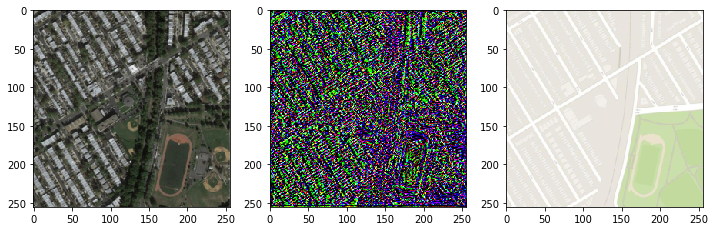

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256]) torch.Size([2, 8, 256, 256]) torch.Size([2, 8, 256, 256])


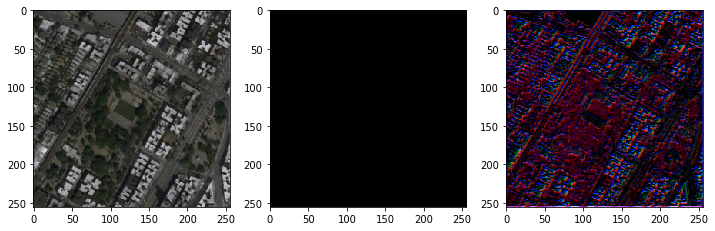

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256]) torch.Size([2, 8, 256, 256]) torch.Size([2, 8, 256, 256])


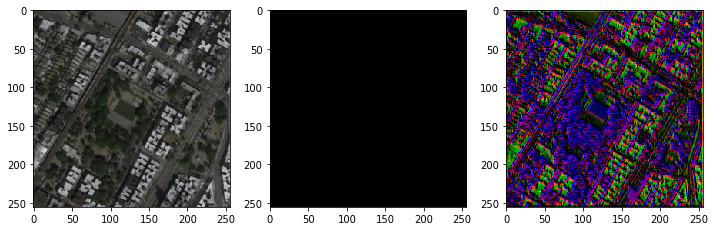

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256]) torch.Size([2, 8, 256, 256]) torch.Size([2, 8, 256, 256])


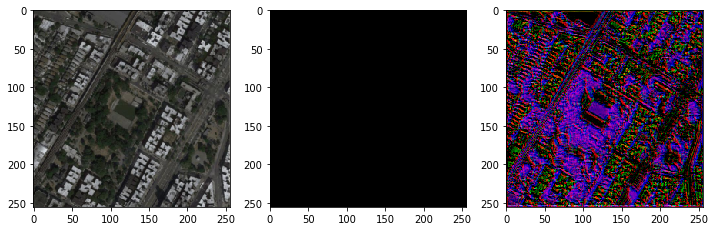

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256]) torch.Size([2, 8, 256, 256]) torch.Size([2, 8, 256, 256])


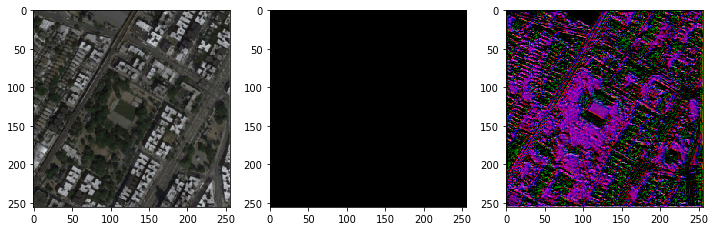

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256]) torch.Size([2, 8, 256, 256]) torch.Size([2, 8, 256, 256])


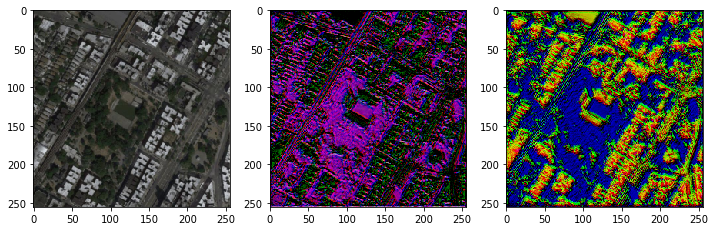

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256]) torch.Size([2, 8, 256, 256]) torch.Size([2, 8, 256, 256])


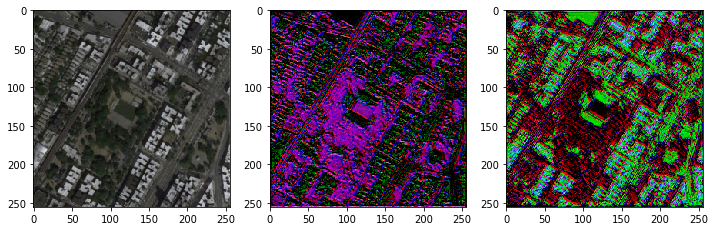

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 256, 256]) torch.Size([2, 8, 256, 256]) torch.Size([2, 8, 256, 256])


KeyboardInterrupt: 

In [21]:
t = time.time()
eta = ''

for ep in range(epoch):
    for i, (image, label) in enumerate(trainloader):
        
        satel_image, map_image = torch.chunk(image, chunks=2, dim=3)
        
        gen_optimizer.zero_grad()
        
        #x = Variable(satel_image).cuda(0) # add .cuda(0) for parallel
        #y_ = Variable(map_image).cuda(0)
        x = Variable(satel_image)
        y_ = Variable(map_image)
        y = generator.forward(x)
        
        current_loss = recon_loss_func(y,y_)
        current_loss.backward()
        gen_optimizer.step()
        
        # status
        dt = time.time() - t
        t = time.time()
        eta = ETA(ep, epoch, i, batch_size, dt,
                      len(trainloader))
        status(batch_size, ep+1 , epoch, i, current_loss,
               trainloader, eta)  
        
        # images display
        if i%10 == 0:
            showAllImages(x,y,y_)
            time.sleep(2)

In [ ]:
    print(xt_1.shape)

In [ ]:
state = (Variable(torch.zeros(2, 5, 256, 256)))

In [ ]:
print(len(state))

In [ ]:
print(state.shape)